# Energy resolution after  delta-z effect correction


### Nov 2020, JAH

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

to_df = pd.DataFrame.from_records

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
#import hipy.hfit         as hfit

import bes.bes           as bes

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed Jan 13 17:00:46 2021


### load data

In [5]:
def get_filename(run_number):
    datadir    = f"/data_extra2/jrenner/analysis/NEW"
    run_number = str(run_number)
    filename   = datadir + f'/{run_number}' + f'/hdf5/cdst/trigger2/cdst_combined_{run_number}' + '.h5'
    return filename

In [6]:
run_number = 8180
selname    = 'ds.rough'
runs       = [run_number,]
filenames  = [get_filename(run) for run in runs]
dft        = bes.get_dft(filenames)

AttributeError: module 'bes.bes' has no attribute 'get_dft'

### selections and ranges

In [7]:
ranges     = bes.get_ranges()
for key in ranges.keys(): print(key, ranges[key])

numb_of_tracks.one (0.5, 1.5)
energy (0.0, 3.0)
energy.cs (0.65, 0.71)
energy.ds (1.55, 1.75)
energy.ph (2.5, 3.0)
enecor.cs (0.65, 0.71)
enecor.ds (1.55, 1.75)
enecor.ph (2.5, 3.0)
z_min (50.0, 500.0)
z_max (50.0, 500.0)
r_max (0.0, 180.0)
dz_track.cs (8.0, 32.0)
dz_track.ds (24.0, 72.0)
dz_track.ph (35.0, 130.0)


In [8]:
selections = bes.Selections(dft, ranges)
selections.logical_and(('numb_of_tracks.one', 'energy', 'z_min', 'z_max', 'r_max'), 'fidutial')
selections.logical_and(('fidutial', 'energy.ds'), 'ds.rough')
selections.logical_and(('fidutial', 'energy.ph'), 'ph.rough')
print(selections)

numb_of_tracks.one : numb_of_tracks [0.5, 1.5],  entries 541769, efficiency 0.69827
energy : energy [0.0, 3.0],  entries 775827, efficiency 0.99993
energy.cs : energy [0.65, 0.71],  entries 19333, efficiency 0.02492
energy.ds : energy [1.55, 1.75],  entries 6484, efficiency 0.00836
energy.ph : energy [2.5, 3.0],  entries 358, efficiency 0.00046
enecor.cs : enecor [0.65, 0.71],  entries 20046, efficiency 0.02584
enecor.ds : enecor [1.55, 1.75],  entries 6519, efficiency 0.00840
enecor.ph : enecor [2.5, 3.0],  entries 604, efficiency 0.00078
z_min : z_min [50.0, 500.0],  entries 668066, efficiency 0.86105
z_max : z_max [50.0, 500.0],  entries 675382, efficiency 0.87047
r_max : r_max [0.0, 180.0],  entries 580268, efficiency 0.74789
dz_track.cs : dz_track [8.0, 32.0],  entries 304119, efficiency 0.39197
dz_track.ds : dz_track [24.0, 72.0],  entries 53314, efficiency 0.06871
dz_track.ph : dz_track [35.0, 130.0],  entries 28831, efficiency 0.03716
fidutial : numb_of_tracks [0.5, 1.5] & ener

### Energy 

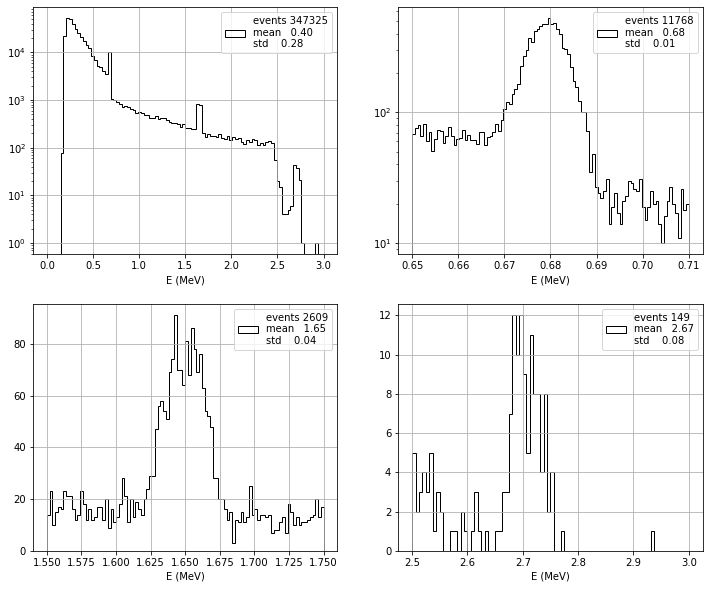

In [9]:
def plt_energies(enes, sel = None):

    xsel = sel if sel is not None else enes > np.min(enes)

    subplot = pltext.canvas(4, 2)
    subplot(1)
    pltext.hist(enes[xsel], 100, range = ranges['energy'], ylog = True, xylabels = 'E (MeV)'); 
    subplot(2)
    pltext.hist(enes[xsel], 100, range = ranges['energy.cs'], ylog = True, xylabels = 'E (MeV)');
    subplot(3)
    pltext.hist(enes[xsel], 100, range = ranges['energy.ds'], xylabels = 'E (MeV)');
    subplot(4)
    pltext.hist(enes[xsel], 80, range  = ranges['energy.ph'], xylabels = 'E (MeV)');


plt_energies(dft.energy, selections['fidutial'])

## Rough selection

selname  ds.rough
numb_of_tracks [0.5, 1.5] & energy [0.0, 3.0] & z_min [50.0, 500.0] & z_max [50.0, 500.0] & r_max [0.0, 180.0] & energy [1.55, 1.75] 2609


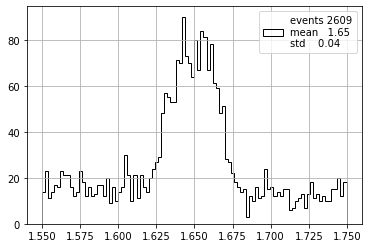

In [10]:
print('selname ', selname)
xsel = selections[selname]
print(xsel.info, np.sum(xsel))                               
evts   = dft[xsel].event.values
pltext.hist(dft[xsel].energy, 100);

In [11]:
## Test

In [12]:
from glob import glob
datadir    = f'/data_extra2/jrenner/analysis/NEW/{run_number}/hdf5/cdst/trigger2/'

fnames = glob(datadir + '/cdst_*.h5')
print(fnames[-1])
fnames = fnames[:-1]
print(fnames[-1])
#fnames = sorted(fnames[:-1], key = lambda s : int(s.split('_')[-6])) # 6


/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_combined_8184.h5
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1750_8184_trigger2_v1.2.0_20191122_bg.h5


In [13]:
fnames = sorted(fnames[:-1], key = lambda s : int(s.split('_')[-6])) # 6

In [14]:
def df_hits(fnames, events, ofname = 'hits.h5'):

    dfhlow, dfhhigh = None, None

    for fname in fnames:
    
        f = tb.open_file(fname, 'r')
            
        dfe = to_df(f.root.DST.Events.read())
        
        xsel = np.isin(dfe.event, events) 
        
        if (np.sum(xsel) > 0): 
                
            print(fname, ' : events selected ', len(np.unique(dfe[xsel].event.values)))
    
            def _append(idf, df):
                
                xsel = np.isin(idf.event.values, events)
        
                xidf = idf[xsel]
            
                df = idf if df is None else df.append(xidf, ignore_index = True)
            
                return df
    
            dfhlow  = _append(to_df(f.root.CHITS.lowTh .read()), dfhlow)
        
            dfhhigh = _append(to_df(f.root.CHITS.highTh.read()), dfhhigh)
        
        f.close()
            
    
    dfhlow .to_hdf(ofname, key = 'CHITs.lowTh' , mode = 'a')
    
    dfhhigh.to_hdf(ofname, key = 'CHITs.highTh', mode = 'a')
    
    
    return dfhlow, dfhhigh        

In [15]:
ofname  = 'chits_' + selname.replace('.', '_') + f'_{run_number}.h5'
print(ofname)
#dfh, dfhh = df_hits(xfnames, evts, ofname)

chits_ds_rough_8184.h5


In [16]:
dfh, dfhh = df_hits(fnames, evts, ofname)

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0004_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0014_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0017_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0019_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0025_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0026_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  3
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0040_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0045_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0271_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0276_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0284_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0293_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0298_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0299_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0300_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0304_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0543_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0552_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0554_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0556_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0558_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0562_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0566_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0571_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0771_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0772_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0776_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0777_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0783_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0785_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0786_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_0791_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1039_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1044_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1045_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1050_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1056_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1060_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1070_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1071_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1320_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1321_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1325_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1326_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1337_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1341_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1345_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1346_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1546_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1548_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1551_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1560_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1563_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1568_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1570_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1571_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1780_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1782_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1784_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1798_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1802_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1803_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1805_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_1807_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2014_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2016_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2019_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2022_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2023_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2026_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2027_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2029_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2235_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2241_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2251_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2253_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2255_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2257_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2258_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2262_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2490_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2491_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2496_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2504_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2507_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2515_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2525_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2526_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2738_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2741_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2742_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2746_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2758_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2760_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2763_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_2769_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3021_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3031_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3036_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3037_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3038_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3040_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3041_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3042_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3255_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3261_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3263_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3264_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3266_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3267_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3269_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3277_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3575_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3576_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3580_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3584_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3588_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3590_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3594_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3595_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3806_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3807_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3814_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3815_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3821_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3822_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3826_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_3828_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4099_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4105_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4106_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4110_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4118_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4121_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4136_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4148_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4398_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4401_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4402_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4403_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4406_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4407_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4409_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4417_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4620_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4626_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4627_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4628_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4630_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4631_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4634_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4642_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4846_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4851_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4854_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4855_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4862_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4867_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4870_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_4871_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5096_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5102_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5103_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5105_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5106_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5107_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5117_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5123_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5366_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5369_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5373_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5374_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5376_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5377_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5379_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5380_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5602_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5604_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5608_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5611_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5621_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5638_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5641_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5650_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5916_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5920_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5922_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5926_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5927_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5929_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5933_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_5934_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6244_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6255_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6256_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  3
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6262_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6268_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6270_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6273_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6280_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6483_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6485_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6495_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6502_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6504_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6506_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6510_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6520_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6711_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6713_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6715_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6716_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6717_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6718_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6720_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6722_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6928_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6930_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6936_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6938_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6939_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6942_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6943_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_6944_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7154_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7160_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7163_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7168_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7172_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7190_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7192_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7193_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7497_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7501_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7506_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7510_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7518_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7525_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7528_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7538_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7764_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7769_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7770_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7771_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7774_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7776_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7780_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_7785_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8010_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8013_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8020_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8026_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8028_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  3
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8035_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8037_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8041_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8282_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8283_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8285_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8288_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8291_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8293_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8295_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8297_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8494_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8496_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8507_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8508_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8513_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8519_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  2
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8521_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8525_8184_trigger2_v1.2.0_20191122_bg.h5  : events sele

/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8723_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8727_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8732_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8735_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8739_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8747_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1
/data_extra2/jrenner/analysis/NEW/8184/hdf5/cdst/trigger2/cdst_8750_8184_trigger2_v1.2.0_20191122_bg.h5  : events selected  1


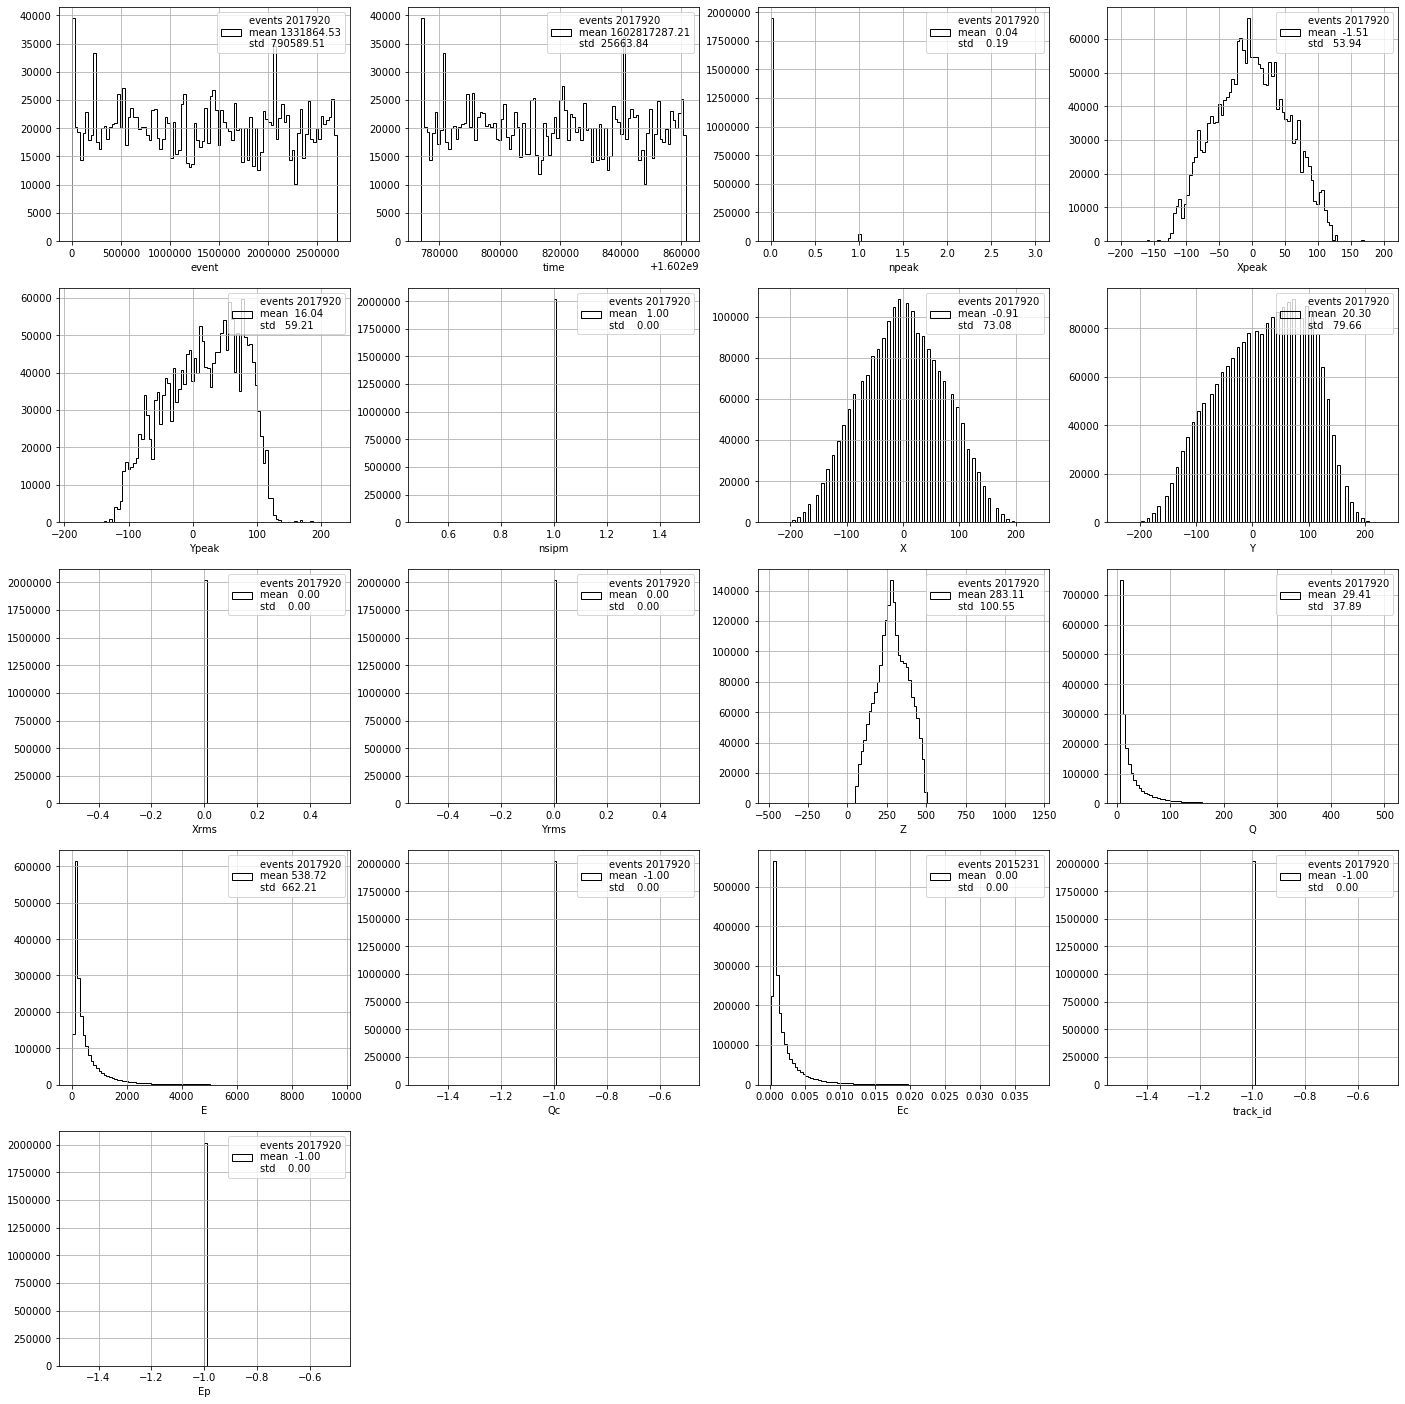

In [17]:
pltext.plt_inspect_df(dfh, ncolumns = 4)

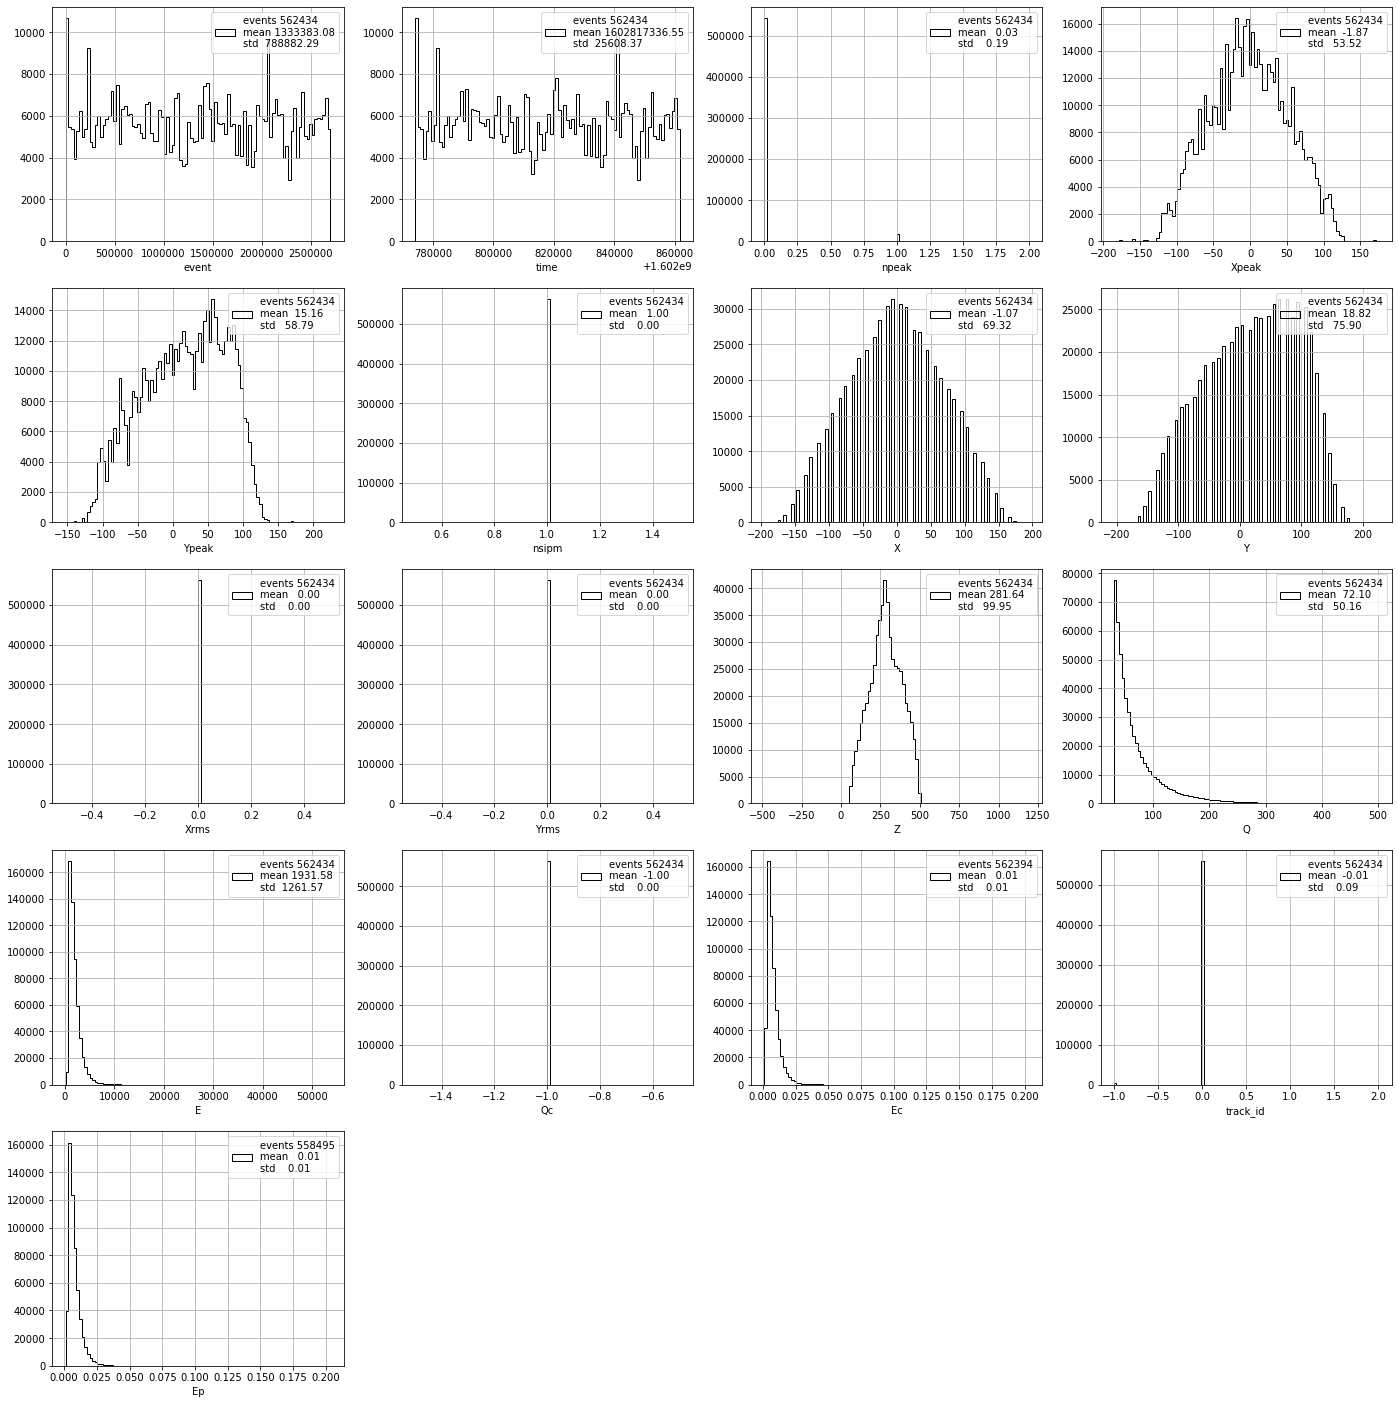

In [18]:
pltext.plt_inspect_df(dfhh, ncolumns = 4)

In [19]:
dfhh

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1252,1.602774e+09,0,-159.452691,-48.458111,1,-95.0,-55.0,0.0,0.0,201.422455,40.213730,1801.934891,-1.0,0.006587,-1,NaN
1,1252,1.602774e+09,0,-159.452691,-48.458111,1,-185.0,-55.0,0.0,0.0,196.014733,116.600113,2305.463828,-1.0,0.011639,0,0.011639
2,1252,1.602774e+09,0,-159.452691,-48.458111,1,-185.0,-65.0,0.0,0.0,196.014733,54.309895,1073.836845,-1.0,0.005595,0,0.005595
3,1252,1.602774e+09,0,-159.452691,-48.458111,1,-195.0,-55.0,0.0,0.0,196.014733,46.529800,920.005728,-1.0,0.004022,0,0.004022
4,1252,1.602774e+09,0,-159.452691,-48.458111,1,-185.0,-55.0,0.0,0.0,197.658472,118.733047,1945.795239,-1.0,0.009827,0,0.009827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562429,2699574,1.602862e+09,0,-123.179980,4.662865,1,-145.0,25.0,0.0,0.0,229.231315,32.520805,1055.795974,-1.0,0.004444,0,0.004444
562430,2699574,1.602862e+09,0,-123.179980,4.662865,1,-145.0,35.0,0.0,0.0,224.132723,61.304947,1435.948195,-1.0,0.006101,0,0.006101
562431,2699574,1.602862e+09,0,-123.179980,4.662865,1,-145.0,35.0,0.0,0.0,225.844997,84.171280,1625.881876,-1.0,0.006909,0,0.006909
562432,2699574,1.602862e+09,0,-123.179980,4.662865,1,-135.0,35.0,0.0,0.0,225.844997,30.282001,584.937730,-1.0,0.002397,0,0.002397


In [108]:
dfhh.columns

Index(['event', 'time', 'npeak', 'Xpeak', 'Ypeak', 'nsipm', 'X', 'Y', 'Xrms',
       'Yrms', 'Z', 'Q', 'E', 'Qc', 'Ec', 'track_id', 'Ep'],
      dtype='object')

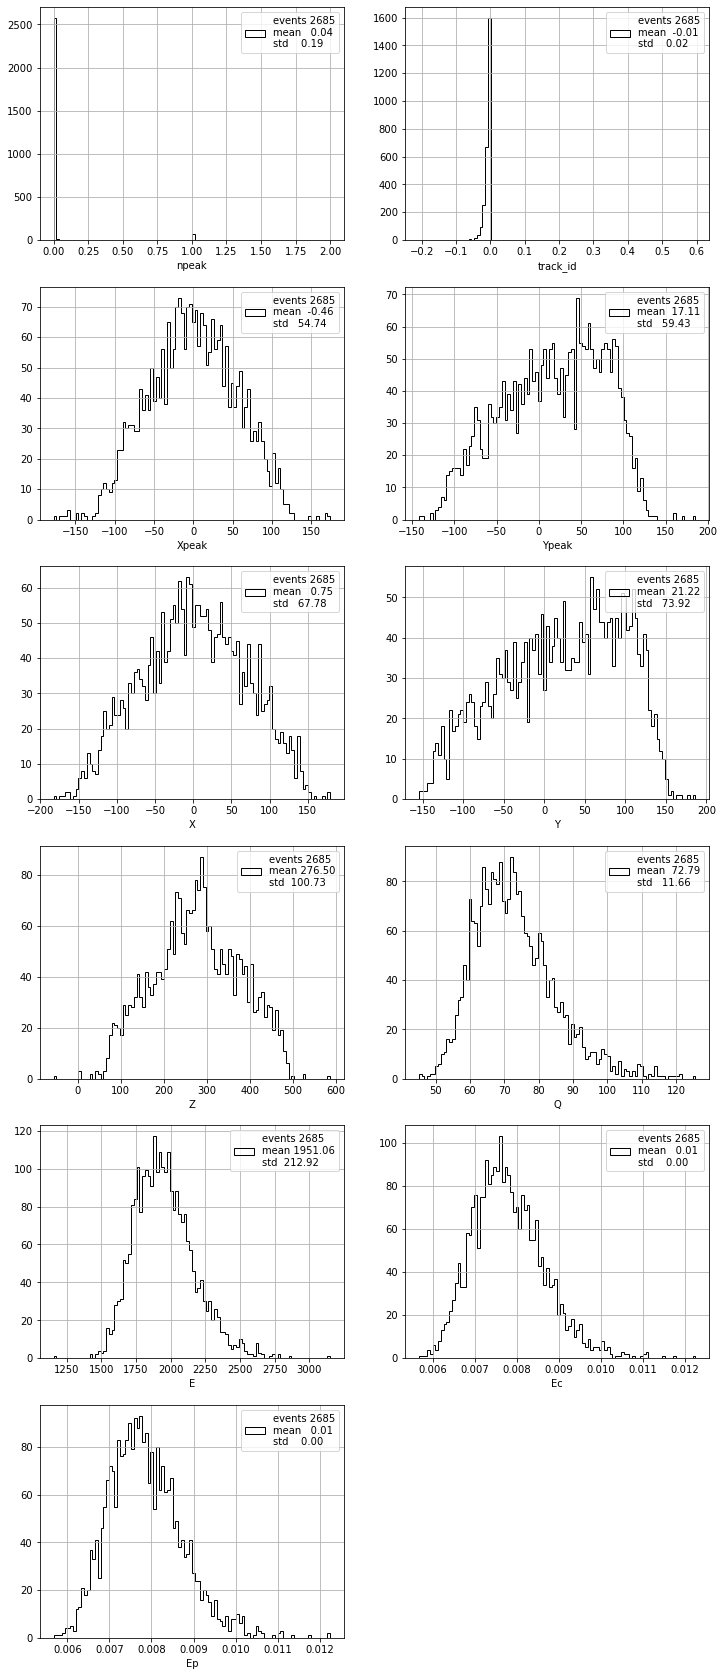

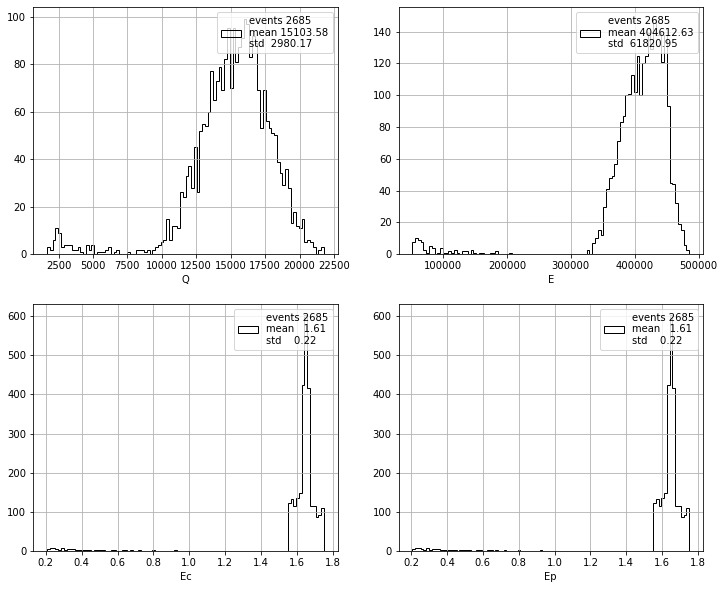

In [123]:
de = dfhh.groupby('event').mean()
labels = ['npeak', 'track_id', 'Xpeak', 'Ypeak', 'X', 'Y', 
           'Z', 'Q', 'E', 'Ec', 'Ep']
pltext.plt_inspect_df(de, labels = labels)

de = dfhh.groupby('event').sum()
labels = ['Q', 'E', 'Ec', 'Ep']
pltext.plt_inspect_df(de, labels = labels)